


### Effect of a **Loyalty** program on Insurance Claims.

---

#### Suppose an insurance company wants to estimate the effect of enrolling customers in a loyalty program on the number of insurance claims they file.


#### There are various methods for **causal inference** (process of determining whether one variable, often called the "treatment" or "cause", directly affects another variable, the "outcome" or "effect"), including **randomized controlled trials (RCTs)**, **instrumental variables (IV), propensity score matching**, and more recently, methods using g**raphical models and machine learning.**

This is different from **correlation**, which simply measures whether two variables **move together**, without implying that one causes the other.


Since customers are not randomly assigned to the loyalty program, there may be **confounding variables** that influence both the enrollment and the outcome (e.g., age, income, past claims history).

**Steps for Propensity Score Application**

**1. Data Preparation:** Create a dataset with treatment, outcome, and covariates.


**2. Propensity Score Estimation:** Estimate the probability of treatment assignment based on observed covariates.

*   Propensity Score is probability of a unit (e.g., a customer) receiving the treatment given their observed characteristics.


**3. Matching/Weighting/Stratification:** Use propensity scores to balance the treatment and control groups.

**4. Outcome Analysis:** Compare the outcomes between the balanced groups to estimate the treatment effect.



In [1]:
import numpy as np
import pandas as pd

# Seed for reproducibility
np.random.seed(42)

# Generate synthetic data
num_samples = 1000
data = {
    'age': np.random.randint(18, 70, size=num_samples),
    'income': np.random.normal(50000, 10000, size=num_samples),
    'past_claims': np.random.randint(0, 5, size=num_samples),
    'loyalty_program': np.random.binomial(1, 0.3, size=num_samples),  # 30% in loyalty program
}

df = pd.DataFrame(data)

# Introduce a causal relationship
df['num_claims'] = df['loyalty_program'] * -0.5 + df['past_claims'] * 0.3 + np.random.normal(0, 1, num_samples)
df['num_claims'] = round(df['num_claims'].apply(lambda x: max(x, 0)))  # Ensure non-negative claims

# Display the first few rows of the dataset
print(df)


     age        income  past_claims  loyalty_program  num_claims
0     56  33935.536797            4                0         2.0
1     69  52034.636359            1                1         0.0
2     46  42436.492547            3                1         1.0
3     32  35777.462904            4                0         0.0
4     60  43534.271158            3                1         0.0
..   ...           ...          ...              ...         ...
995   60  54195.324439            3                1         2.0
996   64  41125.078222            1                0         0.0
997   62  45625.416997            3                0         1.0
998   35  57223.813578            1                0         1.0
999   55  46271.668479            0                1         1.0

[1000 rows x 5 columns]


### **Matching:** Treated units (enrolled in the loyalty program) are matched with control units (not enrolled) based on their propensity scores using nearest neighbor matching.

#### Matching is a method to pair each treated unit with one or more control units that have similar propensity scores. This aims to balance the distribution of observed covariates between the treated and control groups, reducing the bias due to confounding variables.

#### Nearest Neighbor Matching: Each treated unit is matched with the closest control unit(s) based on the propensity score. In this example, we use 1-to-1 nearest neighbor matching.

#### In observational studies, like our insurance, the treatment (enrollment in a loyalty program) is not randomly assigned. This can lead to biased estimates of the treatment effect because the treated and untreated groups might differ in ways that also affect the outcome (number of claims). Matching helps to make these groups comparable.

#### How do we do Matching?
### We use propensity scores, which are the **estimated probabilities that a customer will be in the loyalty program based on their characteristics** (age, income, past claims). We then match each treated customer with one or more control customers who have similar propensity scores.

## Steps in Matching :

**Estimate Propensity Scores:** Use logistic regression to calculate the probability of each customer being in the loyalty program based on their age, income, and past claims.

**Find Matches:** For each customer in the loyalty program (treated), find a customer not in the program (control) with a similar propensity score. This is like finding "twins" based on the probability of receiving the treatment.

**Create Matched Dataset:** Combine the treated customers and their matched controls into a new dataset that will be used for analysis.



In [2]:

from sklearn.linear_model import LogisticRegression

# Define features and treatment
X = df[['age', 'income', 'past_claims']]
y = df['loyalty_program']

# Fit logistic regression to estimate propensity scores
logistic = LogisticRegression()
logistic.fit(X, y)

# Predict propensity scores
df['propensity_score'] = logistic.predict_proba(X)[:, 1]

# Display the first few rows with propensity scores
print(df.head())

   age        income  past_claims  loyalty_program  num_claims  \
0   56  33935.536797            4                0         2.0   
1   69  52034.636359            1                1         0.0   
2   46  42436.492547            3                1         1.0   
3   32  35777.462904            4                0         0.0   
4   60  43534.271158            3                1         0.0   

   propensity_score  
0          0.367947  
1          0.303733  
2          0.337029  
3          0.361145  
4          0.333129  


In [3]:
from sklearn.neighbors import NearestNeighbors

# Separate treated and control groups
treated = df[df['loyalty_program'] == 1]
control = df[df['loyalty_program'] == 0]

# Fit nearest neighbors model
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find nearest neighbors in the control group for each treated unit
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched control units
matched_controls = control.iloc[indices.flatten()]

# Combine treated and matched control units
matched_df = pd.concat([treated, matched_controls])

# Display the first few rows of the matched dataset
print(matched_df.head())


   age        income  past_claims  loyalty_program  num_claims  \
1   69  52034.636359            1                1         0.0   
2   46  42436.492547            3                1         1.0   
4   60  43534.271158            3                1         0.0   
7   56  58816.397569            2                1         1.0   
8   36  49920.273587            1                1         0.0   

   propensity_score  
1          0.303733  
2          0.337029  
4          0.333129  
7          0.281364  
8          0.310908  


### Average treatment effect (ATE) measures the average effect of a treatment on an outcome variable. There are different methods to estimate the ATE but it is often estimated using sample means as :

In [4]:
# Calculate average treatment effect
ate = matched_df[matched_df['loyalty_program'] == 1]['num_claims'].mean() - \
      matched_df[matched_df['loyalty_program'] == 0]['num_claims'].mean()

print(f'Average Treatment Effect (ATE): {ate}')


Average Treatment Effect (ATE): -0.23509933774834435


In [5]:

# Define pre and post periods
pre_period_data = matched_df[matched_df['loyalty_program'] == 1]['num_claims']
post_period_data = matched_df[matched_df['loyalty_program'] == 0]['num_claims']

# Calculate the average treatment effect
ate = np.mean(post_period_data) - np.mean(pre_period_data)


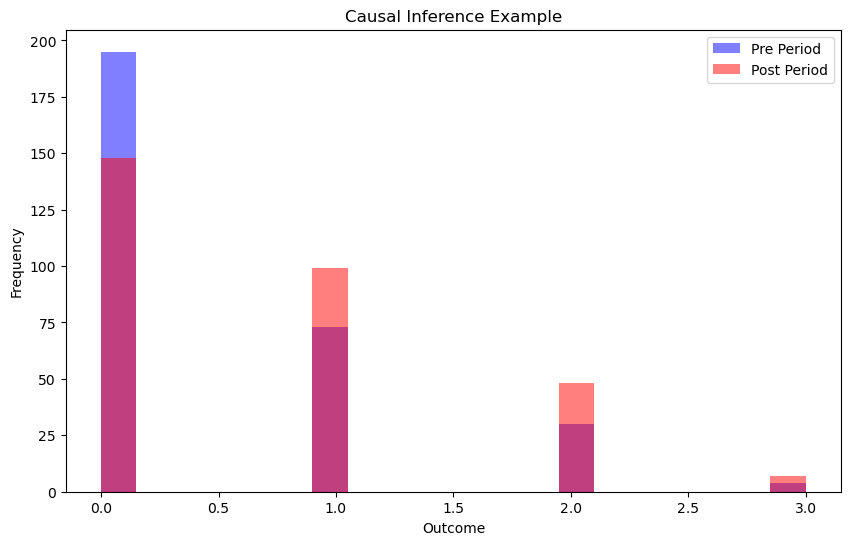

Average Treatment Effect (ATE): 0.23509933774834435


In [6]:
import matplotlib.pyplot as plt
# Plot the data
plt.figure(figsize=(10, 6))
plt.hist(pre_period_data, bins=20, alpha=0.5, color='blue', label='Pre Period')
plt.hist(post_period_data, bins=20, alpha=0.5, color='red', label='Post Period')
#plt.axvline(x=np.mean(pre_period_data), color='blue', linestyle='--', label='Pre Period Mean')
#plt.axvline(x=np.mean(post_period_data), color='red', linestyle='--', label='Post Period Mean')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Causal Inference Example')
plt.legend()
plt.show()

# Print the average treatment effect
print("Average Treatment Effect (ATE):", ate)

## To solve the insurance loyalty claim problem we can also the **DoWhy** library, with thefollowing steps:


Causal Model Specification: Define the causal model including treatment, outcome, and confounders.

Identify the Causal Effect: Use DoWhy to identify the causal effect.

Estimate the Causal Effect: Estimate the causal effect using an appropriate method.

Refute the Estimate: Perform robustness checks to ensure the validity of the causal effect

In [7]:
##!pip install dowhy

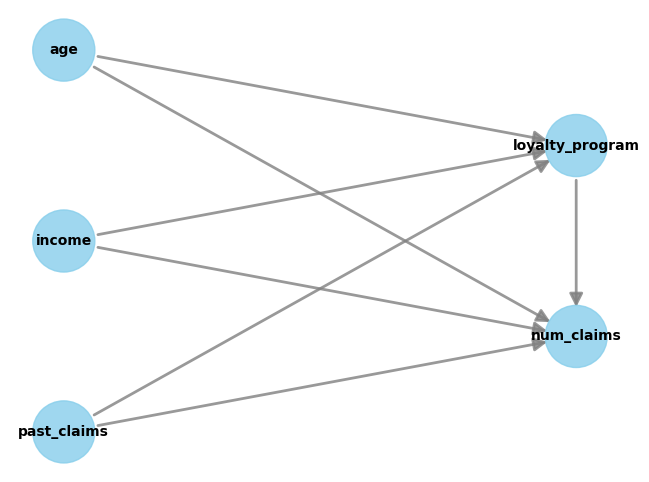

In [8]:

import dowhy
from dowhy import CausalModel

# Define the causal model
model = CausalModel(
    data=df,
    treatment='loyalty_program',
    outcome='num_claims',
    common_causes=['age', 'income', 'past_claims']
)

# View the model
model.view_model()


Methodology: The estimand is identified using backdoor adjustment (in the first estimand) and instrumental variables (in the second estimand), as indicated by the **backdoor** and **iv** names.


Estimand Type: The identified estimand is for the Average Treatment Effect (ATE), which measures the average effect of the treatment on the outcome.

Estimand Expression: This describes the mathematical expression used to estimate the causal effect, typically involving conditional expectations or derivatives.

Estimand Assumptions: These assumptions specify the conditions under which the identified estimand is valid. For example, unconfoundedness assumes that there are no unobserved confounders affecting both the treatment assignment and the outcome.



In [9]:
identified_estimand = model.identify_effect()
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                               
──────────────────(E[num_claims|income,past_claims,age])
d[loyalty_program]                                      
Estimand assumption 1, Unconfoundedness: If U→{loyalty_program} and U→num_claims then P(num_claims|loyalty_program,income,past_claims,age,U) = P(num_claims|loyalty_program,income,past_claims,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Backdoor Estimand: It shows how the loyalty program might change the number of claims people make, once we think about differences in past claims, income, and age. We have to think about what else could affect both the loyalty program and the number of claims.

IV and Frontdoor Estimands: These couldn't be used here because we didn't have good examples of other things that could help us understand how the loyalty program affects the number of claims people make.



In [10]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                               
──────────────────(E[num_claims|income,past_claims,age])
d[loyalty_program]                                      
Estimand assumption 1, Unconfoundedness: If U→{loyalty_program} and U→num_claims then P(num_claims|loyalty_program,income,past_claims,age,U) = P(num_claims|loyalty_program,income,past_claims,age)

## Realized estimand
b: num_claims~loyalty_program+income+past_claims+age
Target units: ate

## Estimate
Mean value: -0.2893802283500893



The estimated ATE of joining the loyalty program on the number of claims is approximately -0.291. This suggests that, on average, joining the loyalty program is associated with a decrease in the number of claims. However, be cautious in interpreting the sign of the estimate (- or +) as it depends on how the outcome variable is coded and the direction of the effect being studied.

# **Refutation**: We perform robustness checks to ensure the causal effect is not due to random chance or unobserved confounders.

In [11]:
# Refute the causal estimate
refutation = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)

print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:-0.2893802283500893
New effect:0.003946370041180225
p value:0.98



### The original estimated effect was -0.2908133591203415, suggesting a negative impact of the treatment.

### After applying the placebo refutation, the new estimated effect is very close to zero (0.003572994964809586), which suggests that the observed effect may be due to a placebo effect or random chance.

The high p-value of 0.96 further supports that the difference between the original and refuted effects is not statistically significant.

## Conclusion:

This refutation suggests that the effect of the treatment is not robust against a placebo treatment. The observed effect is likely to be due to a placebo effect or random chance rather than a true causal effect of the treatment.

## In the context of evaluating the effect of a loyalty program on insurance claims, statistical tests can be used to determine whether the observed differences in claims between customers who participate in the loyalty program and those who do not are statistically significant.



### **Statistical Tests**

**t-Test:** Used to compare the means of two groups (e.g., claims from loyalty program participants vs. non-participants).
    
**Chi-Square Test:** Used to compare categorical variables (e.g., frequency of claims in different groups).

**ANOVA** (Analysis of Variance): Used to compare means across multiple groups.
    
Regression Analysis: Used to understand the relationship between dependent and independent variables (e.g., effect of loyalty program on the number of claims).



**Run t-Test Experiment:**


Collect data over a specified period.

Analyze the Data:
Calculate the means and standard deviations of claims for both groups.Ensure that the data collection is consistent and covers the necessary sample size.



**Effect Size:**

Effect size is a measure used to quantify the magnitude of the difference or relationship between variables in a statistical analysis

𝑑= (mean control − mean treatment )/ std_dev


**Sample Size**:

Determine the sample size needed to detect the effect size with desired power (typically 0.8 or 80%) and significance level (α, typically 0.05).


𝑛=(𝑍𝛼/2 +𝑍𝛽)^2 * 2*𝜎^2 /effect size


Use Z-scores for the desired confidence level (e.g., Z = 1.96 for 95% confidence) and power (e.g., Z = 0.84 for 80% power).






In [12]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
from scipy import stats
import math

#
mean_control = 100
mean_treatment = 80
std_dev = 20
alpha = 0.05  # Significance level
power = 0.8  # Desired power

# Step 2: Calculate Effect Size (Cohen's d)
effect_size = (mean_treatment - mean_control ) / std_dev
print(f"Effect Size (Cohen's d): {effect_size}")

# Step 3: Calculate Required Sample Size
z_alpha = stats.norm.ppf(1 - alpha / 2)
z_beta = stats.norm.ppf(power)

sample_size = (2* (z_alpha + z_beta) ** 2  * (std_dev ** 2) )/ effect_size ** 2
sample_size = math.ceil(sample_size)
print(f"Required Sample Size per Group: {sample_size}")

# Calculate Statistical Power
# Using observed effect size and recalculating Z value
power_analysis = TTestIndPower()

power = power_analysis.solve_power(effect_size=effect_size, nobs1=sample_size, alpha=alpha, ratio=1.0, alternative='two-sided')

print("Statistical Power:", power) # the probability that a statistical test will correctly reject the null hypothesis when it is false

Effect Size (Cohen's d): -1.0
Required Sample Size per Group: 6280
Statistical Power: 1.0


In [13]:
# Step 4: Simulate Data Collection
np.random.seed(42)
control_group = np.random.normal(mean_control, std_dev, sample_size)
treatment_group = np.random.normal(mean_treatment, std_dev, sample_size)

# Create DataFrame
data = pd.DataFrame({
    'group': ['control'] * sample_size + ['treatment'] * sample_size,
    'claims': np.concatenate([control_group, treatment_group])
})
data

,group,claims
0,control,109.934283
1,control,97.234714
2,control,112.953771
3,control,130.460597
4,control,95.316933
...,...,...
12555,treatment,50.096048
12556,treatment,80.161335
12557,treatment,79.845827
12558,treatment,57.567075



**Implement the Experiment:**

Perform a hypothesis test (e.g., t-test) to compare the means of the two groups.

Ensure randomization to avoid bias.

**Hypothesis**: "The new loyalty program reduces the average number of insurance claims."

**Null hypothesis (𝐻0)**: The loyalty program has no effect on the number of claims.

**Alternative hypothesis (𝐻1)**: The loyalty program reduces the number of claims.


**p-value**: The probability of obtaining the observed results if the null hypothesis is true. A low p-value (typically < 0.05) indicates that the null hypothesis can be rejected.



T-statistic: 56.442494746027165, P-value: 0.0


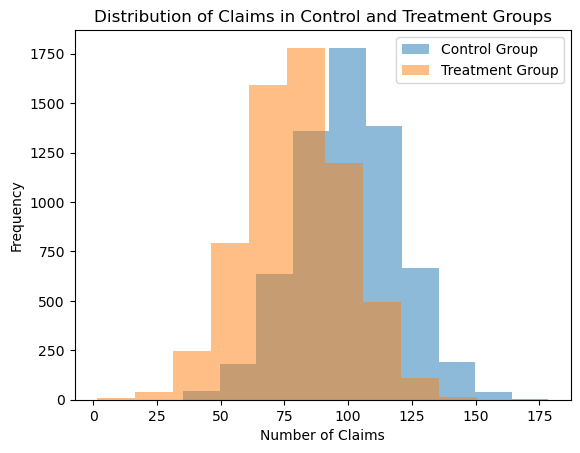

In [14]:
# Perform A/B test
control_group = data[data['group'] == 'control']['claims']
treatment_group = data[data['group'] == 'treatment']['claims']

t_stat, p_value = stats.ttest_ind(control_group, treatment_group)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

# Plotting the distributions
plt.hist(control_group, alpha=0.5, label='Control Group')
plt.hist(treatment_group, alpha=0.5, label='Treatment Group')
plt.legend(loc='upper right')
plt.xlabel('Number of Claims')
plt.ylabel('Frequency')
plt.title('Distribution of Claims in Control and Treatment Groups')
plt.show()

**Determine the Number of Days Required:**

Estimate how long you need to run the test to collect the required sample size.


days = sample size /(daily visitors × proportion eligible)



In [15]:
# Step 7: Determine Number of Days Required
daily_claim = 200
proportion_eligible = 0.5  # Assuming equal split

days_required = sample_size / (daily_claim * proportion_eligible)
print(f"Number of Days Required to Run the Test: {math.ceil(days_required)} days")


Number of Days Required to Run the Test: 63 days


In [16]:
# Confidence interval for the mean difference
mean_diff = np.mean(control_group) - np.mean(treatment_group)
se_diff = np.sqrt((np.var(control_group)/sample_size) + (np.var(treatment_group)/sample_size))
confidence_interval_diff = stats.norm.interval(1-alpha, loc=mean_diff, scale=se_diff)
print(f"95% Confidence Interval for the Mean Difference: {confidence_interval_diff}")

95% Confidence Interval for the Mean Difference: (19.422519804965926, 20.819822712133718)
